## Load packages

In [1]:
# Load libraries

library(tidyverse)
library(stringr)
library(lubridate)
library(ggthemes)
library(hrbrthemes)
library(ggalt)
library(forcats)

# optionally: load fonts used by hrbrthemes
# Suggested code from: https://github.com/hrbrmstr/hrbrthemes/issues/18

d <- read.csv(extrafont:::fonttable_file(), stringsAsFactors = FALSE)
d[grepl("Light", d$FontName),]$FamilyName <- font_rc_light
write.csv(d,extrafont:::fonttable_file(), row.names = FALSE)
extrafont::loadfonts()

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.3.4     ✔ dplyr   0.7.4
✔ tidyr   0.7.2     ✔ stringr 1.2.0
✔ readr   1.1.1     ✔ forcats 0.2.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date

Registering font with R using pdfFonts(): Roboto Condensed
Registering font with R using pdfFonts(): Roboto Condensed Light


## Load in data to visualize

In [2]:
# List of accused

alleg_list <- read_csv("../data/alleg_list.csv") %>% .$alleg_list

alleg_list

Parsed with column specification:
cols(
  alleg_list = col_character()
)


[1] "harvey weinstein"   "chris savino"       "robert scoble"     
 [4] "lockhart steele"    "josh besh"          "terry richardson"  
 [7] "leon wieseltier"    "knight landesman"   "rick najera"       
[10] "mark halperin"      "ken baker"          "kevin spacey"      
[13] "hamilton fish"      "michael oreskes"    "andy dick"         
[16] "kirt webster"       "brett ratner"       "jeff hoover"       
[19] "david guillod"      "benjamin genocchio" "louis ck"          
[22] "roy moore"          "al franken"         "richard dreyfuss"  
[25] "gary goddard"       "dustin hoffman"     "robert knepper"    
[28] "andrew kreisberg"   "jeremy piven"       "steven seagal"     
[31] "tom sizemore"       "jeffrey tambor"     "george takei"      
[34] "james toback"       "matthew weiner"     "stephen blackwell" 
[37] "jann wenner"        "matt zimmerman"     "stephen bittel"    
[40] "jeff clemens"       "jack latvala"       "michael fallon"    
[43] "alex gilady"        "danny jordaan"      "sepp blatter"      
[46] "glenn thrush"       "charlie rose"       "john lasseter"     
[49] "matt lauer"         "garrison keillor"   "john conyers"      
[52] "israel horovitz"    "russell simmons"    "nick carter"       
[55] "james levine"       "ruben kihuen"       "blake farenthold"  
[58] "lorin stein"        "danny masterson"    "matt dababneh"     
[61] "david sweeney"      "trent franks"       "wes goodman"       
[64] "tony cornish"       "warren moon"

In [3]:
## Daily TV data

alleg_tv_data_recent <- read_csv("../data/tv_daily/alleg_tv_data_recent.csv")

Parsed with column specification:
cols(
  date_start = col_date(format = ""),
  date_end = col_datetime(format = ""),
  date_resolution = col_character(),
  station = col_character(),
  value = col_integer(),
  name = col_character()
)


In [4]:
## Hourly TV data

show_mentions_recent_data <- read_csv("../data/tv_hourly/show_mentions_recent_data.csv")

Parsed with column specification:
cols(
  date_start = col_datetime(format = ""),
  date_end = col_datetime(format = ""),
  date_resolution = col_character(),
  station = col_character(),
  value = col_integer(),
  name = col_character(),
  time_period = col_date(format = "")
)


In [5]:
## Google trends data

alleg_search_long <- read_csv("../data/google_trends/alleg_search_long.csv")

gtrends_max_values <- read_csv("../data/google_trends/gtrends_max_values.csv")

Parsed with column specification:
cols(
  date = col_datetime(format = ""),
  name = col_character(),
  value = col_integer()
)
Parsed with column specification:
cols(
  name = col_character(),
  max_value_by_name = col_integer()
)


In [6]:
# Minor cosmetic change: 'FOX' -> 'Fox'

alleg_tv_data_recent$station <-
alleg_tv_data_recent$station %>%
  str_replace('FOX', 'Fox')

show_mentions_recent_data$station <-
show_mentions_recent_data$station %>%
  str_replace('FOX', 'Fox')

## Aggregate data for visualizations

### Daily data

In [7]:
alleg_tv_data_recent %>% head()

date_start,date_end,date_resolution,station,value,name
2017-10-01,2017-10-01 23:59:59,day,Bloomberg,0,harvey weinstein
2017-10-01,2017-10-01 23:59:59,day,CNBC,0,harvey weinstein
2017-10-01,2017-10-01 23:59:59,day,CNN,0,harvey weinstein
2017-10-01,2017-10-01 23:59:59,day,Fox Business,0,harvey weinstein
2017-10-01,2017-10-01 23:59:59,day,Fox News,0,harvey weinstein
2017-10-01,2017-10-01 23:59:59,day,MSNBC,0,harvey weinstein


In [8]:
# All daily data is updated within a day, but may return zero values for last 24 hours
# Just use data between 10/1 and yesterday

alleg_tv_date_person <-
alleg_tv_data_recent %>%
    group_by(date_start, name) %>%
    summarise(count_date_person = sum(value))

alleg_tv_date_station <-
alleg_tv_data_recent %>%
    group_by(date_start, station) %>%
    summarise(count_date_station = sum(value))

alleg_tv_date_person_station <-
alleg_tv_data_recent %>%
    group_by(date_start, name, station) %>%
    summarise(count_date_person_station = sum(value))

alleg_tv_date_station_weinstein_moore_others <-
alleg_tv_data_recent %>%
    mutate(w_m_other = 
           case_when(
               name == "harvey weinstein" ~ "Weinstein",
               name == "roy moore" ~ "Moore",
               TRUE ~ "Others")
          ) %>%
    group_by(date_start, station, w_m_other) %>%
    summarise(count_date_station_w_m_other = sum(value))

alleg_tv_date_station_weinstein_others <-
alleg_tv_data_recent %>%
    filter(name != "roy moore") %>%
    mutate(w_other = 
           case_when(
               name == "harvey weinstein" ~ "Weinstein",
               TRUE ~ "Others")
          ) %>%
    group_by(date_start, station, w_other) %>%
    summarise(count_date_station_w_other = sum(value))

### Hourly data

In [9]:
show_mentions_person_station_date <-
show_mentions_recent_data %>%
  mutate(date = floor_date(date_start, "day"),
         mention_show = case_when(
             value == 0 ~ 0,
             value > 0 ~ 1)
        ) %>%
  group_by(date, station, name) %>%
  summarise(count_show_mentions_person_station_date = sum(mention_show)) %>%
  filter(station %in% c("CNN", "Fox News", "MSNBC"))

show_mentions_person_station_date %>% head()

show_mentions_person_date <- 
show_mentions_person_station_date %>%
  group_by(date, name) %>%
  summarise(count_show_mentions_person_date = sum(count_show_mentions_person_station_date)) %>%
  arrange(date)

show_mentions_person_date %>% head()

show_mentions_person <- 
show_mentions_person_station_date %>%
  group_by(name) %>%
  summarise(count_show_mentions_person = sum(count_show_mentions_person_station_date)) %>%
  arrange(count_show_mentions_person)

show_mentions_person %>% head()

show_mentions_date_station_weinstein_moore_others<-
show_mentions_person_station_date %>%
    mutate(w_m_other = 
           case_when(
               name == "harvey weinstein" ~ "Weinstein",
               name == "roy moore" ~ "Moore",
               TRUE ~ "Others")
          ) %>%
    group_by(date, station, w_m_other) %>%
    summarise(count_date_station_w_m_other = sum(count_show_mentions_person_station_date))

show_mentions_date_station_weinstein_moore_others %>% head

date,station,name,count_show_mentions_person_station_date
2017-10-01,CNN,glenn thrush,0
2017-10-01,CNN,harvey weinstein,0
2017-10-01,CNN,roy moore,1
2017-10-01,Fox News,harvey weinstein,0
2017-10-01,Fox News,roy moore,5
2017-10-01,MSNBC,glenn thrush,0


date,name,count_show_mentions_person_date
2017-10-01,glenn thrush,0
2017-10-01,harvey weinstein,0
2017-10-01,mark halperin,0
2017-10-01,matt lauer,0
2017-10-01,roy moore,10
2017-10-01,ruben kihuen,0


name,count_show_mentions_person
matthew weiner,1
nick carter,1
gary goddard,2
michael fallon,2
george takei,3
matt zimmerman,3


date,station,w_m_other,count_date_station_w_m_other
2017-10-01,CNN,Moore,1
2017-10-01,CNN,Others,0
2017-10-01,CNN,Weinstein,0
2017-10-01,Fox News,Moore,5
2017-10-01,Fox News,Weinstein,0
2017-10-01,MSNBC,Moore,4


## For each data set: find max values of coverage to place names of accused in visualizations

### Daily data

In [10]:
# Max values of coverage by name
alleg_tv_date_person_max_values <-
alleg_tv_date_person %>%
  group_by(name) %>%
  summarise(max_value_by_name = max(count_date_person, na.rm=TRUE)) %>%
  arrange(-max_value_by_name)

alleg_tv_date_person_max_values %>% head
alleg_tv_date_person_max_values %>% tail

name,max_value_by_name
roy moore,1107
harvey weinstein,524
al franken,516
matt lauer,405
charlie rose,285
john conyers,238


name,max_value_by_name
robert scoble,0
sepp blatter,0
terry richardson,0
tom sizemore,0
tony cornish,0
wes goodman,0


In [11]:
# Mark where each name is at max point the first time

alleg_tv_date_person_max_labels <-
  alleg_tv_date_person %>%
  left_join(., alleg_tv_date_person_max_values, by='name') %>%
  mutate(max = case_when(count_date_person == max_value_by_name ~ count_date_person)) %>%
  select(date_start, name, max) %>%
  arrange(desc(max)) %>%
  group_by(name) %>%
  filter(row_number(max) == 1)

alleg_tv_date_person_max_labels %>% head
alleg_tv_date_person_max_labels %>% tail

date_start,name,max
2017-11-16,roy moore,1107
2017-10-11,harvey weinstein,524
2017-11-17,al franken,516
2017-11-30,matt lauer,405
2017-11-21,charlie rose,285
2017-11-27,john conyers,238


date_start,name,max
2017-10-01,robert scoble,0
2017-10-01,sepp blatter,0
2017-10-01,terry richardson,0
2017-10-01,tom sizemore,0
2017-10-01,tony cornish,0
2017-10-01,wes goodman,0


In [12]:
# Join max values back in with the long table
# Add title case name label at max point

title_caser <- function(x){
str_replace(x, "louis ck", "Louis CK") %>%
  tools::toTitleCase()
}

alleg_tv_date_person_labeled <-
  left_join(alleg_tv_date_person, alleg_tv_date_person_max_labels, by=c('date_start','name')) %>%
  mutate(max_name = case_when(count_date_person == max ~ title_caser(name),
                          TRUE ~ ""))

alleg_tv_date_person_labeled %>% head
alleg_tv_date_person_labeled %>% tail

date_start,name,count_date_person,max,max_name
2017-10-01,al franken,0,NA,
2017-10-01,andy dick,0,NA,
2017-10-01,blake farenthold,0,NA,
2017-10-01,brett ratner,0,NA,
2017-10-01,charlie rose,2,NA,
2017-10-01,danny masterson,0,NA,


date_start,name,count_date_person,max,max_name
2017-12-07,terry richardson,0,NA,
2017-12-07,tom sizemore,0,NA,
2017-12-07,tony cornish,0,NA,
2017-12-07,trent franks,13,13,Trent Franks
2017-12-07,warren moon,1,1,Warren Moon
2017-12-07,wes goodman,0,NA,


### Hourly data

In [13]:
# Max values of coverage by name
show_mentions_person_date_max_values <-
show_mentions_person_date %>%
  group_by(name) %>%
  summarise(max_value_by_name = max(count_show_mentions_person_date, na.rm=TRUE)) %>%
  arrange(-max_value_by_name)

show_mentions_person_date_max_values %>% head
show_mentions_person_date_max_values %>% tail

name,max_value_by_name
roy moore,64
al franken,59
charlie rose,57
harvey weinstein,55
john conyers,48
matt lauer,47


name,max_value_by_name
richard dreyfuss,2
gary goddard,1
matthew weiner,1
michael fallon,1
nick carter,1
ruben kihuen,1


In [14]:
# Mark where each name is at max point the first time

show_mentions_person_date_max_labels <-
  show_mentions_person_date %>%
  left_join(., show_mentions_person_date_max_values, by='name') %>%
  mutate(max = case_when(count_show_mentions_person_date == max_value_by_name ~ count_show_mentions_person_date)) %>%
  select(date, name, max) %>%
  arrange(desc(max)) %>%
  group_by(name) %>%
  filter(row_number(max) == 1)

show_mentions_person_date_max_labels %>% head
show_mentions_person_date_max_labels %>% tail

date,name,max
2017-11-15,roy moore,64
2017-12-07,al franken,59
2017-11-21,charlie rose,57
2017-10-11,harvey weinstein,55
2017-11-22,john conyers,48
2017-11-30,matt lauer,47


date,name,max
2017-12-06,brett ratner,2
2017-10-02,ruben kihuen,1
2017-11-01,michael fallon,1
2017-11-11,gary goddard,1
2017-11-18,matthew weiner,1
2017-11-23,nick carter,1


In [15]:
# Join max values back in with the long table
# Add title case name label at max point

show_mentions_person_date_labeled <-
  left_join(show_mentions_person_date, show_mentions_person_date_max_labels, by=c('date','name')) %>%
  mutate(max_name = case_when(count_show_mentions_person_date == max ~ title_caser(name),
                          TRUE ~ ""))

show_mentions_person_date_labeled %>% head
show_mentions_person_date_labeled %>% tail

date,name,count_show_mentions_person_date,max,max_name
2017-10-01,glenn thrush,0,NA,
2017-10-01,harvey weinstein,0,NA,
2017-10-01,mark halperin,0,NA,
2017-10-01,matt lauer,0,NA,
2017-10-01,roy moore,10,NA,
2017-10-01,ruben kihuen,0,NA,


date,name,count_show_mentions_person_date,max,max_name
2017-12-08,louis ck,0,NA,
2017-12-08,mark halperin,2,NA,
2017-12-08,matt lauer,1,NA,
2017-12-08,roy moore,59,NA,
2017-12-08,ruben kihuen,0,NA,
2017-12-08,trent franks,41,41,Trent Franks


### Google Trends data

In [16]:
# for visualization, mark where each name is at max point the first time

alleg_search_long_max_labels <-
  alleg_search_long %>%
  left_join(., gtrends_max_values, by='name') %>%
  mutate(max = case_when(value == max_value_by_name ~ value)) %>%
  select(date, name, max) %>%
  arrange(desc(max)) %>%
  group_by(name) %>%
  filter(row_number(max) == 1)

alleg_search_long_max_labels %>% head
alleg_search_long_max_labels %>% tail

date,name,max
2017-11-29 06:00:00,matt lauer,100
2017-10-30 05:00:00,kevin spacey,29
2017-10-11 05:00:00,harvey weinstein,20
2017-11-21 06:00:00,charlie rose,19
2017-11-10 06:00:00,louis ck,16
2017-11-16 06:00:00,al franken,12


date,name,max
2017-11-21 06:00:00,john lasseter,1
2017-11-22 06:00:00,nick carter,1
2017-12-04 06:00:00,james levine,1
2017-12-07 06:00:00,trent franks,1
2017-11-17 06:00:00,wes goodman,1
2017-12-07 06:00:00,warren moon,1


In [17]:
# Join max values back in with the long table
# Add title case name label at max point

alleg_search_long_labeled <-
  left_join(alleg_search_long, alleg_search_long_max_labels, by=c('date','name')) %>%
  mutate(max_name = case_when(value == max ~ title_caser(name),
                          TRUE ~ ""))

alleg_search_long_labeled %>% head
alleg_search_long_labeled %>% tail

date,name,value,max,max_name
2017-10-01 05:00:00,harvey weinstein,0,NA,
2017-10-02 05:00:00,harvey weinstein,0,NA,
2017-10-03 05:00:00,harvey weinstein,0,NA,
2017-10-04 05:00:00,harvey weinstein,0,NA,
2017-10-05 05:00:00,harvey weinstein,2,NA,
2017-10-06 05:00:00,harvey weinstein,5,NA,


date,name,value,max,max_name
2017-12-02 06:00:00,warren moon,0,NA,
2017-12-03 06:00:00,warren moon,0,NA,
2017-12-04 06:00:00,warren moon,0,NA,
2017-12-05 06:00:00,warren moon,0,NA,
2017-12-06 06:00:00,warren moon,0,NA,
2017-12-07 06:00:00,warren moon,1,1,Warren Moon


## Save new data as CSV for each aggregated table

### Daily data

In [18]:
write_csv(alleg_tv_date_person, "../data/tv_daily/for_charts/alleg_tv_date_person.csv")

write_csv(alleg_tv_date_station, "../data/tv_daily/for_charts/alleg_tv_date_station.csv")

write_csv(alleg_tv_date_person_station, "../data/tv_daily/for_charts/alleg_tv_date_person_station.csv")

write_csv(alleg_tv_date_station_weinstein_moore_others, "../data/tv_daily/for_charts/alleg_tv_date_station_weinstein_moore_others.csv")

write_csv(alleg_tv_date_station_weinstein_others, "../data/tv_daily/for_charts/alleg_tv_date_station_weinstein_others.csv")

write_csv(alleg_tv_date_person_labeled, "../data/tv_daily/for_charts/alleg_tv_date_person_labeled.csv")

### Hourly data

In [19]:
write_csv(show_mentions_person_station_date, "../data/tv_hourly/for_charts/show_mentions_person_station_date.csv")

write_csv(show_mentions_person, "../data/tv_hourly/for_charts/show_mentions_person.csv")

write_csv(show_mentions_person_date, "../data/tv_hourly/for_charts/show_mentions_person_date.csv")

write_csv(show_mentions_person_date_labeled, "../data/tv_hourly/for_charts/show_mentions_person_date_labeled.csv")

### Google Trends data

In [20]:
write_csv(alleg_search_long_labeled, "../data/google_trends/for_charts/alleg_search_long_labeled.csv")

## Visualize daily TV data

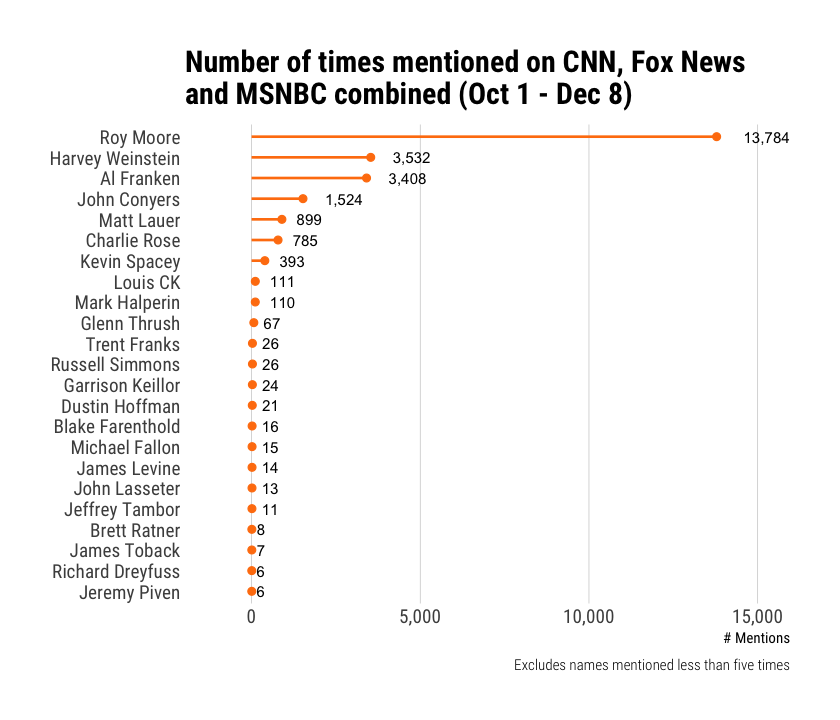

In [21]:
options(repr.plot.width=7, repr.plot.height=6) # just sets size in Jupyter nb

# chart_count_person <-
alleg_tv_date_person %>%
  group_by(name) %>%
  summarise(count = sum(count_date_person)) %>%
  mutate(name = title_caser(name)) %>%
  filter(count > 4) %>%
  ggplot() +
  geom_lollipop(aes(count, reorder(name, count)), horizontal=TRUE, size=0.75,
                color=ggthemes::tableau_color_pal()(10)[2]) +
  geom_text(aes(count, reorder(name, count), label=scales::comma(count)), hjust=-0.58, size = 3.2) + 
   scale_x_continuous(expand=c(0.14,4), label=scales::comma, limits=c(0,14000)) +
  labs(y=NULL, x="# Mentions",
       title=paste0("Number of times mentioned on CNN, Fox News \nand MSNBC combined (Oct 1 - ", 
                    format(lubridate::today() - 1, format="%b%e"), ")"),
       caption = "Excludes names mentioned less than five times" 
      ) +
  theme_minimal() +
  theme_ipsum_rc(grid="X") +
  theme(panel.grid.minor.y=element_blank(),panel.grid.major.y=element_blank())

In [22]:
hw_covered_days <-
left_join(
    (alleg_tv_data_recent %>%
      select(date = date_start, station, name, value) %>%
      filter(name == 'harvey weinstein') %>%
      filter(station %in% c("CNN", "Fox News", "MSNBC")) %>%
      mutate(hw_covered = if_else(value > 0, "Mentioned", "Not mentioned"))
     ),
    (alleg_tv_data_recent %>%
      select(date = date_start, station, name, value) %>%
      filter(name == 'harvey weinstein') %>%
      filter(station %in% c("CNN", "Fox News", "MSNBC")) %>%
     group_by(date, name) %>%
     summarise(hw_covered_all = if_else(sum(value) > 0,1,0)) %>%
     select(-name)
      ), by = 'date'
) %>% mutate(hw_covered_not_at_all = case_when(hw_covered_all == 0 ~ "No Mentions on any channel",
                               TRUE ~ hw_covered))

hw_covered_days %>% head
hw_covered_days %>% tail

date,station,name,value,hw_covered,hw_covered_all,hw_covered_not_at_all
2017-10-01,CNN,harvey weinstein,0,Not mentioned,0,No Mentions on any channel
2017-10-01,Fox News,harvey weinstein,0,Not mentioned,0,No Mentions on any channel
2017-10-01,MSNBC,harvey weinstein,0,Not mentioned,0,No Mentions on any channel
2017-10-02,CNN,harvey weinstein,0,Not mentioned,0,No Mentions on any channel
2017-10-02,Fox News,harvey weinstein,0,Not mentioned,0,No Mentions on any channel
2017-10-02,MSNBC,harvey weinstein,0,Not mentioned,0,No Mentions on any channel


date,station,name,value,hw_covered,hw_covered_all,hw_covered_not_at_all
2017-12-06,CNN,harvey weinstein,2,Mentioned,1,Mentioned
2017-12-06,Fox News,harvey weinstein,6,Mentioned,1,Mentioned
2017-12-06,MSNBC,harvey weinstein,7,Mentioned,1,Mentioned
2017-12-07,CNN,harvey weinstein,2,Mentioned,1,Mentioned
2017-12-07,Fox News,harvey weinstein,5,Mentioned,1,Mentioned
2017-12-07,MSNBC,harvey weinstein,4,Mentioned,1,Mentioned


In [23]:
days_no_weinstein <- 
hw_covered_days %>%
  filter(hw_covered_not_at_all == "No Mentions on any channel") %>%
  .$date %>%
  unique()

days_no_weinstein

[1] "2017-10-01" "2017-10-02" "2017-10-03" "2017-10-04" "2017-11-01"
[6] "2017-11-06"

Since Oct 4, Weinstein was only *not* mentioned on two days, Nov. 1, and Nov. 6

In [24]:
hw_covered_days %>% head

date,station,name,value,hw_covered,hw_covered_all,hw_covered_not_at_all
2017-10-01,CNN,harvey weinstein,0,Not mentioned,0,No Mentions on any channel
2017-10-01,Fox News,harvey weinstein,0,Not mentioned,0,No Mentions on any channel
2017-10-01,MSNBC,harvey weinstein,0,Not mentioned,0,No Mentions on any channel
2017-10-02,CNN,harvey weinstein,0,Not mentioned,0,No Mentions on any channel
2017-10-02,Fox News,harvey weinstein,0,Not mentioned,0,No Mentions on any channel
2017-10-02,MSNBC,harvey weinstein,0,Not mentioned,0,No Mentions on any channel


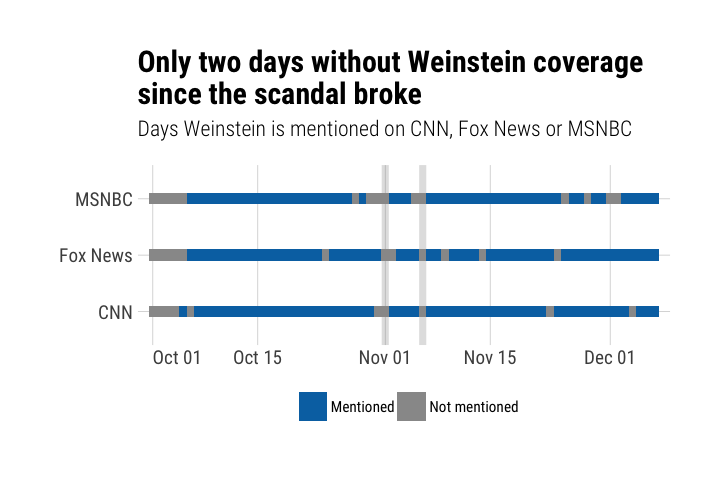

In [25]:
# When is Weinstein mentioned

options(repr.plot.width=6, repr.plot.height=4)

ggplot(hw_covered_days, aes(as.Date(date), station)) +
  geom_vline(xintercept=c(as.Date("2017-11-01"), as.Date("2017-11-06")), 
             size = 2, color = "#999999", alpha=0.3) +
  geom_tile(aes(fill=factor(hw_covered)), height = 0.2) +
#   geom_tile(aes(fill=factor(hw_covered)), height = 0.2) +
  scale_fill_manual(values=c("#0072B2", "#999999")) + 
  scale_x_date(name=NULL, expand=c(0,1.5)) +
  scale_y_discrete(name=element_blank()) +
  theme_minimal() +
#    ggthemes::scale_fill_tableau(name=NULL) +
   labs(title="Only two days without Weinstein coverage \nsince the scandal broke",
       subtitle="Days Weinstein is mentioned on CNN, Fox News or MSNBC") +
   theme_ipsum_rc(grid="XY") +
   theme(axis.text.x=element_text(hjust=c(0, 0.5, 0.5, 0.5, 0.5, 0.5)), 
         legend.title = element_blank(), legend.position="bottom")


Warning message:
“Removed 3 rows containing missing values (geom_text).”

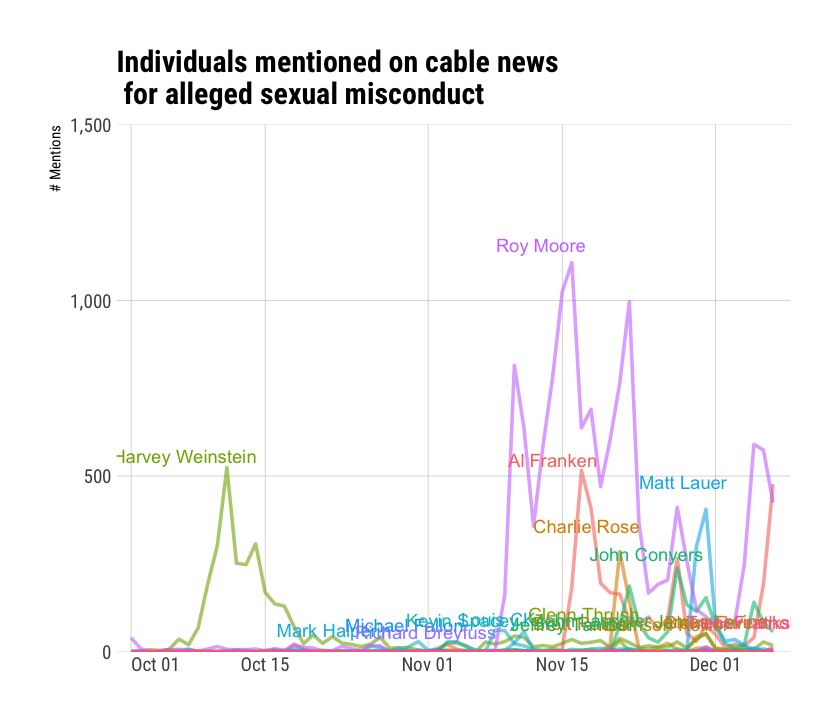

In [26]:
options(repr.plot.width=7, repr.plot.height=6)

# chart_date_person <-
ggplot() +
  geom_line(data = alleg_tv_date_person_labeled, 
            stat="identity", 
            aes(date_start, count_date_person, color=name),
           size=1, alpha=0.6) +
  geom_text(data = alleg_tv_date_person_labeled %>%
              mutate(max = as.numeric(max)) %>%
              filter(!is.na(max)) %>%
              filter(max > 2),
              aes(date_start, count_date_person, label = max_name, color = name), 
              alpha = 1, vjust = -1, hjust=0.8, position = position_jitter(height = 30)) +
  scale_x_date(name=NULL, expand=c(0,1.5)) +
  scale_y_continuous(name="# Mentions", label=scales::comma, limits=c(0, 1500), expand=c(0,0)) +
  theme_minimal() +
  ggthemes::scale_fill_tableau(name=NULL) +
  labs(title="Individuals mentioned on cable news \n for alleged sexual misconduct ") +
  theme_ipsum_rc(grid="XY") +
  theme(axis.text.x=element_text(hjust=c(0, 0.5, 0.5, 0.5, 0.5, 0.5)), legend.position="none")

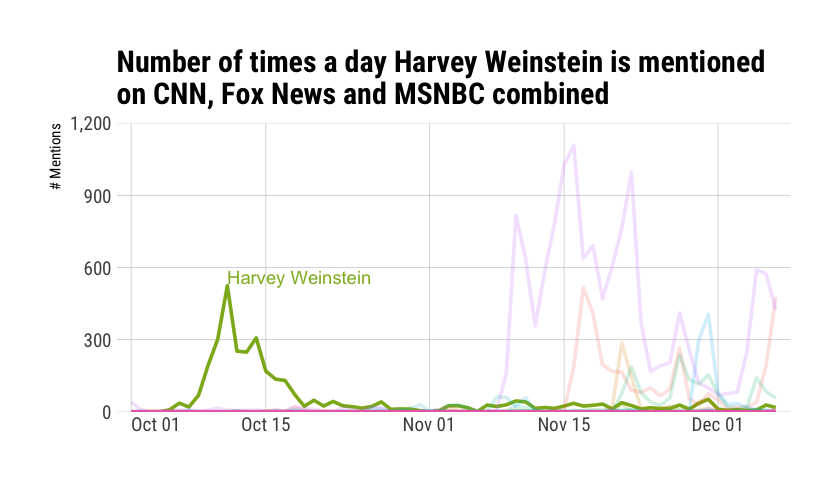

In [27]:
# Highlighting Weinstein
options(repr.plot.width=7, repr.plot.height=4)

filter_list <- c("roy moore", "al franken", "charlie rose", "matt lauer", "john conyers", "harvey weinstein")

ggplot() +
  geom_line(data = alleg_tv_date_person_labeled %>%
            filter(name == "harvey weinstein"), 
            stat="identity", 
            aes(date_start, count_date_person, color=name),
           size=1, alpha=0.9) +
  geom_line(data = alleg_tv_date_person_labeled, 
            stat="identity", 
            aes(date_start, count_date_person, color=name),
           size=1, alpha=0.2) +
  geom_text(data = alleg_tv_date_person_labeled %>%
            filter(name=="harvey weinstein") %>%
            mutate(max = as.numeric(max)) %>%
            filter(!is.na(max)) %>%
            filter(max > 2) %>%
            filter(name %in% filter_list), # highlighting rose, moore, franken, lauer
            aes(date_start, count_date_person, label = max_name, color = name), 
            alpha = 0.9, vjust = -0.2, hjust=0) +
  scale_x_date(name=NULL, expand=c(0,1.5)) +
  scale_y_continuous(name="# Mentions", label=scales::comma, limits=c(0, 1200), expand=c(0,0)) +
  theme_minimal() +
  ggthemes::scale_fill_tableau(name=NULL) +
  labs(title="Number of times a day Harvey Weinstein is mentioned \non CNN, Fox News and MSNBC combined") +
  theme_ipsum_rc(grid="XY") +
  theme(axis.text.x=element_text(hjust=c(0, 0.5, 0.5, 0.5, 0.5, 0.5)), legend.position="none")

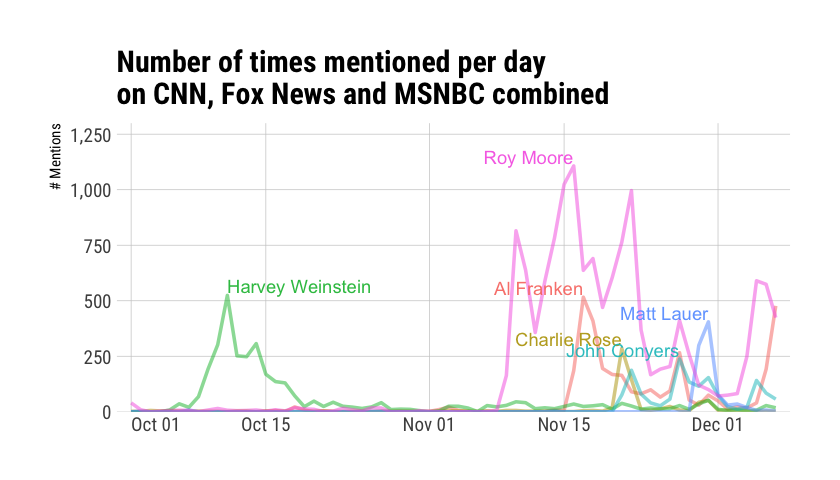

In [28]:
# Highlighting Moore, Franken, Rose, Lauer, Conyers and Weinstein
options(repr.plot.width=7, repr.plot.height=4)

filter_list <- c("roy moore", "al franken", "charlie rose", "matt lauer", "john conyers", "harvey weinstein")


# chart_date_person <-
ggplot() +
  geom_line(data = alleg_tv_date_person_labeled %>%
            filter(name %in% filter_list), # highlighting rose, moore, franken, lauer
            stat="identity", 
            aes(date_start, count_date_person, color=name),
           size=1, alpha=0.5) +
  geom_text(data = alleg_tv_date_person_labeled %>%
            mutate(max = as.numeric(max)) %>%
            filter(!is.na(max)) %>%
            filter(max > 2) %>%
            filter(name %in% filter_list[1:5]), # highlighting rose, moore, franken, lauer
            aes(date_start, count_date_person, label = max_name, color = name), 
            alpha = 0.9, vjust = -0.2, hjust=1) +
  geom_text(data = alleg_tv_date_person_labeled %>%
            filter(name=="harvey weinstein") %>%
            mutate(max = as.numeric(max)) %>%
            filter(!is.na(max)) %>%
            filter(max > 2) %>%
            filter(name %in% filter_list), # highlighting rose, moore, franken, lauer
            aes(date_start, count_date_person, label = max_name, color = name), 
            alpha = 0.9, vjust = -0.2, hjust=0) +
  scale_x_date(name=NULL, expand=c(0,1.5)) +
  scale_y_continuous(name="# Mentions", label=scales::comma, limits=c(0, 1300), expand=c(0,0)) +
  theme_minimal() +
  ggthemes::scale_fill_tableau(name=NULL) +
  labs(title="Number of times mentioned per day\non CNN, Fox News and MSNBC combined") +
  theme_ipsum_rc(grid="XY") +
  theme(axis.text.x=element_text(hjust=c(0, 0.5, 0.5, 0.5, 0.5, 0.5)), legend.position="none")

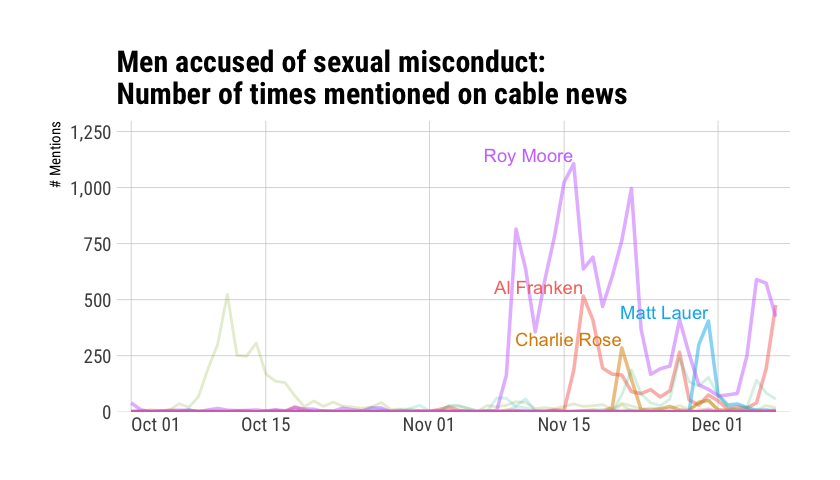

In [29]:
# Highlighting Moore and Franken
options(repr.plot.width=7, repr.plot.height=4)

filter_list <- c("roy moore", "al franken", "charlie rose", "matt lauer")

ggplot() +
  geom_line(data = alleg_tv_date_person_labeled %>%
            filter(name %in% filter_list), # highlighting rose, moore, franken, lauer
            stat="identity", 
            aes(date_start, count_date_person, color=name),
           size=1, alpha=0.5) +
  geom_line(data = alleg_tv_date_person_labeled %>%
            filter(!(name %in% filter_list)), # highlighting rose, moore, franken, lauer, 
            stat="identity", 
            aes(date_start, count_date_person, color=name),
           size=0.8, alpha=0.2) +
  geom_text(data = alleg_tv_date_person_labeled %>%
            mutate(max = as.numeric(max)) %>%
            filter(!is.na(max)) %>%
            filter(max > 2) %>%
            filter(name %in% filter_list), # highlighting rose, moore, franken, lauer
            aes(date_start, count_date_person, label = max_name, color = name), 
            alpha = 1, vjust = -0.2, hjust=1) +
  scale_x_date(name=NULL, expand=c(0,1.5)) +
  scale_y_continuous(name="# Mentions", label=scales::comma, limits=c(0, 1300), expand=c(0,0)) +
  theme_minimal() +
  ggthemes::scale_fill_tableau(name=NULL) +
  labs(title="Men accused of sexual misconduct: \nNumber of times mentioned on cable news") +
  theme_ipsum_rc(grid="XY") +
  theme(axis.text.x=element_text(hjust=c(0, 0.5, 0.5, 0.5, 0.5, 0.5)), legend.position="none")

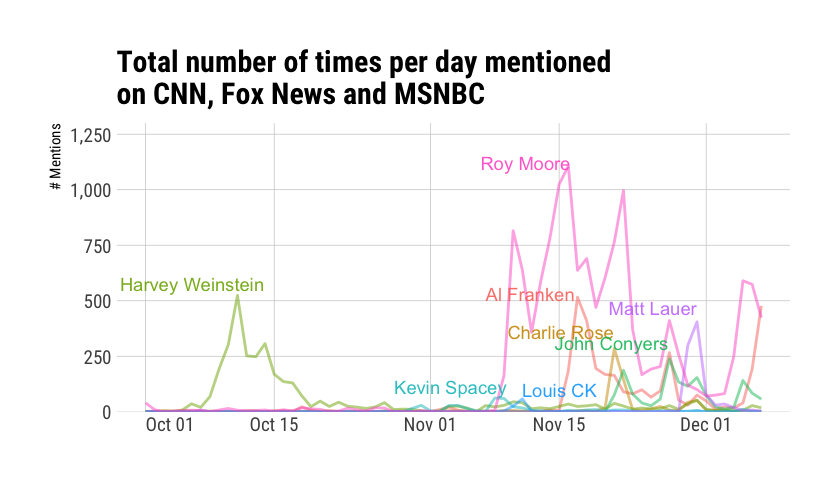

In [30]:
# Highlighting CK and Spacey
options(repr.plot.width=7, repr.plot.height=4)

text_placement_list <- c("harvey weinstein", 'roy moore', 'al franken', 
                               'charlie rose', 'john conyers', 'matt lauer', 
                               "louis ck", "kevin spacey")

filter_stay <- c('roy moore', 'al franken', 'charlie rose', 'john conyers', 'matt lauer')


text_placement <-
alleg_tv_date_person_labeled %>%
            mutate(max = as.numeric(max)) %>%
            filter(!is.na(max)) %>%
            filter(max > 2) %>%
            filter(name %in% text_placement_list) %>%
            arrange(name)

ggplot() +
  geom_line(data = alleg_tv_date_person_labeled %>%
            filter(name %in% text_placement_list),
            stat="identity", 
            aes(date_start, count_date_person, color=name),
           size=0.8, alpha=0.5) +
  geom_text(data = text_placement %>%
            filter(name %in% filter_stay), # Other
            aes(date_start, count_date_person, label = max_name, color = name), 
            alpha = 0.9, vjust = -0.2, hjust=1, position = position_jitter(height = 40)) +
  geom_text(data = text_placement %>%
            filter(name == "harvey weinstein"), # moving Weinstein
            aes(date_start, count_date_person, label = max_name, color = name), 
            alpha = 0.9, hjust=0.8, vjust = -0.2, position = position_jitter(height = 15)) +
  geom_text(data = text_placement %>%
            filter(name == "louis ck"), # moving ck
            aes(date_start, count_date_person, label = max_name, color = name), 
            alpha = 0.9, vjust = -0.2, hjust=0, position = position_jitter(height = 15)) +
  geom_text(data = text_placement %>%
            filter(name == "kevin spacey"), # moving spacey
            aes(date_start, count_date_person, label = max_name, color = name), 
            alpha = 0.9, vjust = -0.2, hjust=0.9, position = position_jitter(height = 15)) +
  scale_x_date(name=NULL, expand=c(0.02,1.8)) +
  scale_y_continuous(name="# Mentions", label=scales::comma, limits=c(0, 1300), expand=c(0,0)) +
  theme_minimal() +
  ggthemes::scale_fill_tableau(name=NULL) +
  labs(title="Total number of times per day mentioned \non CNN, Fox News and MSNBC") +
  theme_ipsum_rc(grid="XY") +
  theme(axis.text.x=element_text(hjust=c(0, 0.5, 0.5, 0.5, 0.5, 0.5)), legend.position="none")

Warning message:
“Removed 12 rows containing missing values (geom_text).”

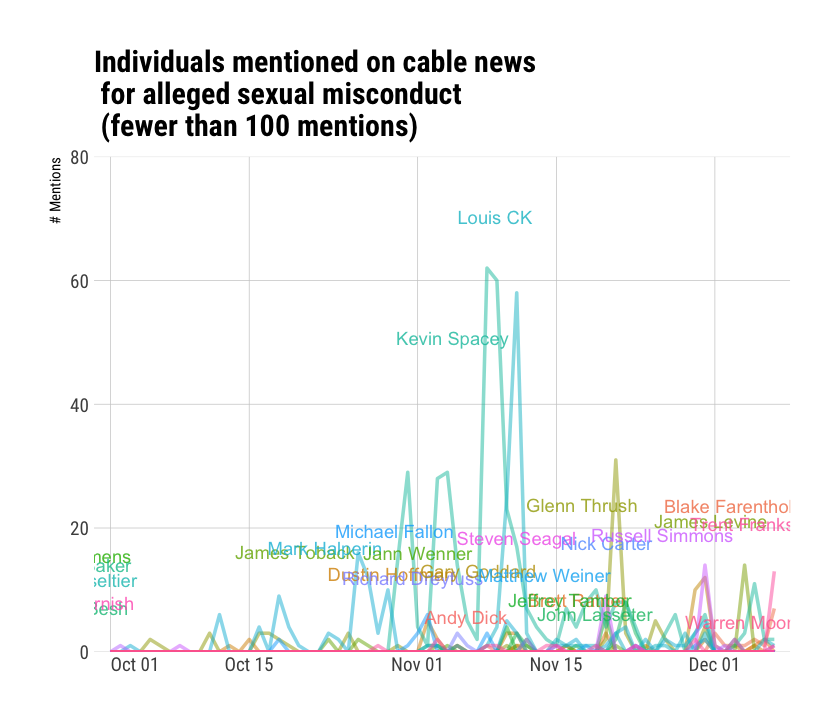

In [31]:
# Highlighting those with fewer mentions
options(repr.plot.width=7, repr.plot.height=6)

filter_list <- c("roy moore", "al franken", "charlie rose", "matt lauer", 
                 "harvey weinstein", "john conyers")

ggplot() +
  geom_line(data = alleg_tv_date_person_labeled %>%
            filter(!(name %in% filter_list)), 
            stat="identity", 
            aes(date_start, count_date_person, color=name),
           size=1, alpha=0.5) +
  geom_text(data = alleg_tv_date_person_labeled %>%
            filter(!(name %in% filter_list)) %>%
            mutate(max = as.numeric(max)) %>%
            filter(!is.na(max)),
            aes(date_start, count_date_person, label = max_name, color = name), 
            alpha = 0.8, vjust = -1, hjust=0.8, position = position_jitter(height = 15)) +
  scale_x_date(name=NULL, expand=c(0,1.5)) +
  scale_y_continuous(name="# Mentions", label=scales::comma, limits=c(0, 80), expand=c(0,0)) +
  theme_minimal() +
  ggthemes::scale_fill_tableau(name=NULL) +
  labs(title="Individuals mentioned on cable news \n for alleged sexual misconduct \n (fewer than 100 mentions) ") +
  theme_ipsum_rc(grid="XY") +
  theme(axis.text.x=element_text(hjust=c(0, 0.5, 0.5, 0.5, 0.5, 0.5)), legend.position="none")

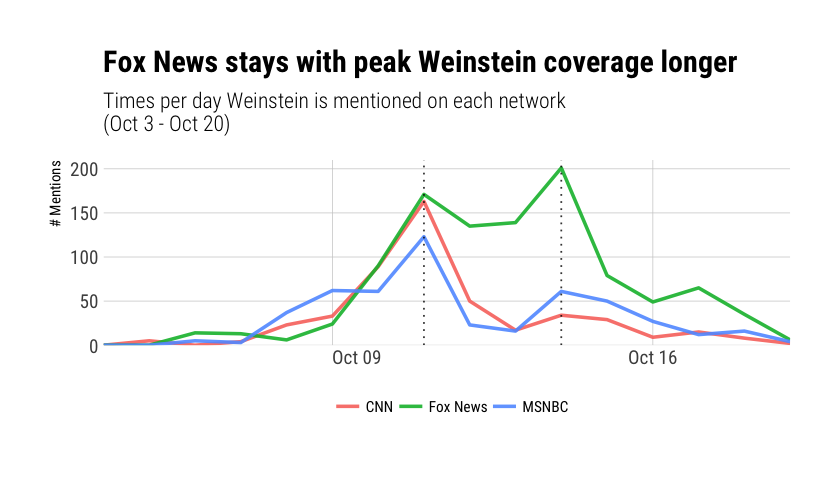

In [32]:
options(repr.plot.width=7, repr.plot.height=4)

ggplot() +
  geom_line(data = alleg_tv_date_person_station %>% 
            filter(date_start > as.Date("2017-10-3") & date_start < as.Date("2017-10-20")) %>%
            filter(station %in% c("Fox News", "CNN", "MSNBC")) %>%
            filter(name == "harvey weinstein"),
            stat="identity", aes(date_start, count_date_person_station, color=station),
            size=1, alpha=0.9)+
  geom_vline(xintercept=c(as.Date("2017-10-11"), as.Date("2017-10-14")), linetype=3, alpha=0.8) +
  scale_x_date(name=NULL, expand=c(0,0)) +
  scale_y_continuous(name="# Mentions", label=scales::comma, limits=c(0, 210), expand=c(0,0)) +
  ggthemes::scale_fill_tableau(name=NULL) +
  labs(subtitle="Times per day Weinstein is mentioned on each network\n(Oct 3 - Oct 20)",
       title= "Fox News stays with peak Weinstein coverage longer") +
  theme_minimal() +
  theme_ipsum_rc(grid="XY") +
  theme(axis.text.x=element_text(hjust=c(0, 0.5, 0.5, 0.5, 0.5, 0.5)),
       legend.title = element_blank(),
        legend.position="bottom")

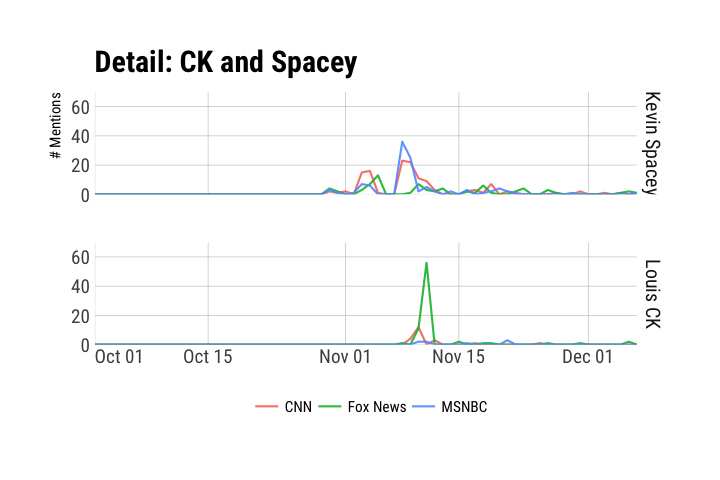

In [33]:
options(repr.plot.width=6, repr.plot.height=4)

ggplot() +
  geom_line(data = alleg_tv_date_person_station %>% 
            filter(station %in% c("Fox News", "CNN", "MSNBC")) %>%
            filter(name %in% c("kevin spacey", "louis ck")) %>%
            mutate(tname = title_caser(name)),
            stat="identity", aes(date_start, count_date_person_station, color=station),
            size=0.6, alpha=0.9) +
  facet_grid(tname ~ .) +
  scale_x_date(name=NULL, expand=c(0,0)) +
  scale_y_continuous(name="# Mentions", label=scales::comma, limits=c(0, 70), expand=c(0,0)) +
   ggthemes::scale_fill_tableau(name=NULL) +
  labs(title="Detail: CK and Spacey") +
  theme_minimal() +
  theme_ipsum_rc(grid="XY") +
  theme(legend.position="bottom", legend.title = element_blank()) +
  theme(axis.text.x=element_text(hjust=c(0, 0.5, 0.5, 0.5, 0.5, 0.5)))

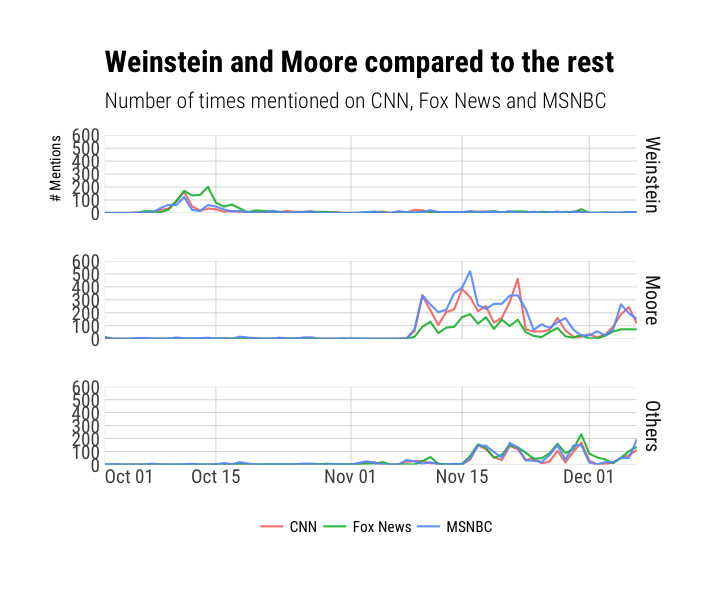

In [34]:
options(repr.plot.width=6, repr.plot.height=5)

# alleg_tv_date_station_weinstein_moore_others <-
#   mutate(w_m_other = fct_relevel(factor(w_m_other), "Weinstein")

ggplot() +
  geom_line(data = alleg_tv_date_station_weinstein_moore_others %>% 
            filter(station %in% c("Fox News", "CNN", "MSNBC")) %>%
            mutate(w_m_other = fct_relevel(factor(w_m_other), "Weinstein")),
              stat="identity", aes(date_start, count_date_station_w_m_other, color=station),
           size=0.6, alpha=0.9)+
  facet_grid(w_m_other ~ .) +
  scale_x_date(name=NULL, expand=c(0,0)) +
  scale_y_continuous(name="# Mentions", label=scales::comma, limits=c(0, 600), expand=c(0,0)) +
   ggthemes::scale_fill_tableau(name=NULL) +
  labs(title="Weinstein and Moore compared to the rest",
      subtitle="Number of times mentioned on CNN, Fox News and MSNBC") +
  theme_minimal() +
  theme_ipsum_rc(grid="XY") +
  theme(legend.position="bottom", legend.title = element_blank()) +
  theme(axis.text.x=element_text(hjust=c(0, 0.5, 0.5, 0.5, 0.5, 0.5)))

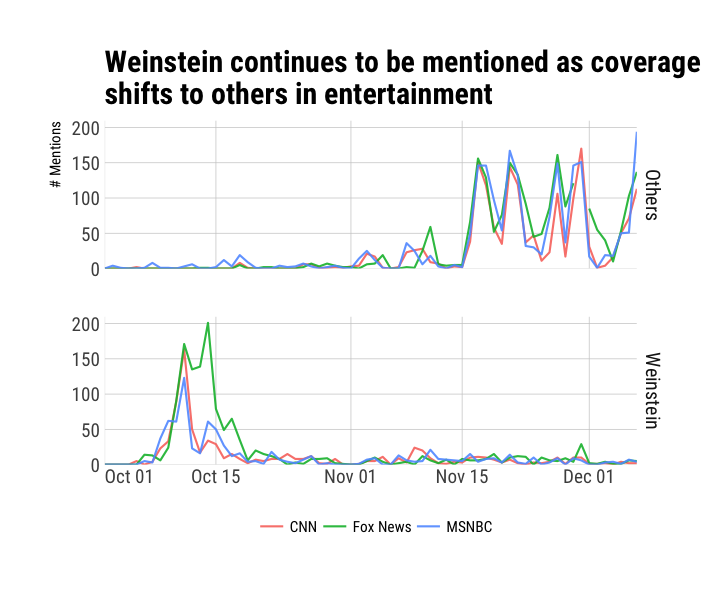

In [35]:
ggplot() +
  geom_line(data = alleg_tv_date_station_weinstein_others %>% 
            filter(station %in% c("Fox News", "CNN", "MSNBC")),
            stat="identity", aes(date_start, count_date_station_w_other, color=station),
            size=0.6, alpha=0.9) +
  facet_grid(w_other ~ .) +
  scale_x_date(name=NULL, expand=c(0,0)) +
  scale_y_continuous(name="# Mentions", label=scales::comma, limits=c(0, 210), expand=c(0,0)) +
  labs(title="Weinstein continues to be mentioned as coverage \nshifts to others in entertainment") +
  theme_minimal() +
  theme_ipsum_rc(grid="XY") +
  theme(axis.text.x=element_text(hjust=c(0, 0.5, 0.5, 0.5, 0.5, 0.5)),
        legend.title = element_blank(),
        legend.position="bottom")

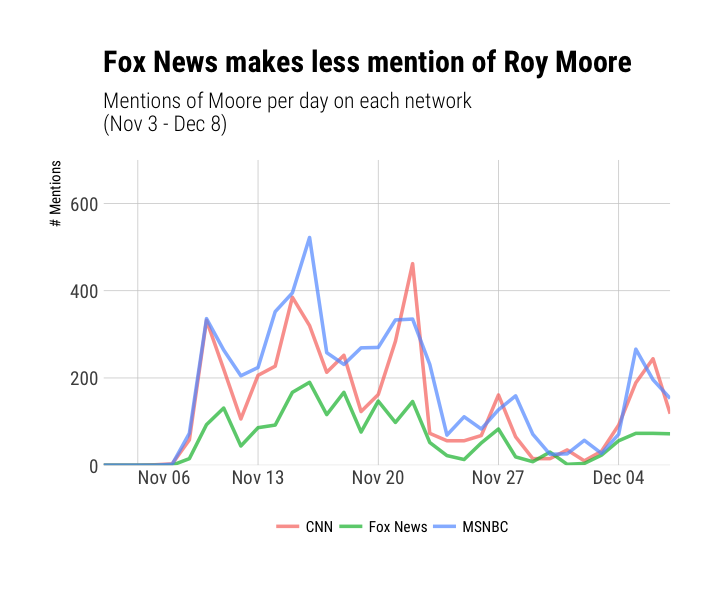

In [36]:
options(repr.plot.width=6, repr.plot.height=5)

ggplot() +
  geom_line(data = alleg_tv_date_person_station %>% 
            filter(date_start > as.Date("2017-11-3")) %>%
            filter(station %in% c("Fox News", "CNN", "MSNBC")) %>%
            filter(name == "roy moore"),
            stat="identity", aes(date_start, count_date_person_station, color=station),
            size=1, alpha=0.7) +
  scale_x_date(name=NULL, expand=c(0,0)) +
  scale_y_continuous(name="# Mentions", label=scales::comma, limits=c(0, 700), expand=c(0,0)) +
  labs(subtitle=paste0("Mentions of Moore per day on each network\n(Nov 3 - ",
                    format(lubridate::today() - 1, format="%b%e"), ")"),
      title = "Fox News makes less mention of Roy Moore") +
  theme_minimal() +
  theme_ipsum_rc(grid="XY") +
  theme(axis.text.x=element_text(hjust=c(0, 0.5, 0.5, 0.5, 0.5, 0.5)),
        legend.position="bottom", legend.title = element_blank())

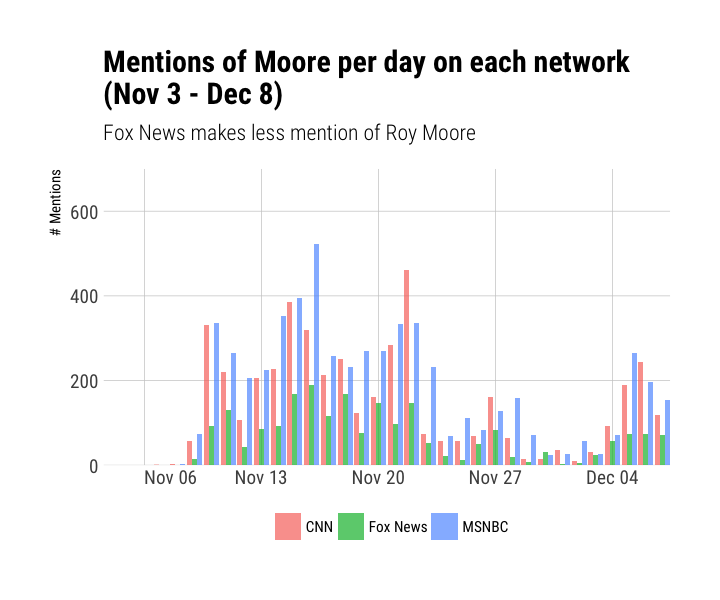

In [37]:
# bar chart of mentions of Moore since Nov 3 (small bars)

options(repr.plot.width=6, repr.plot.height=5)

ggplot() +
  geom_bar(data = alleg_tv_date_person_station %>% 
            filter(date_start > as.Date("2017-11-3")) %>%
            filter(station %in% c("Fox News", "CNN", "MSNBC")) %>%
            filter(name == "roy moore"),
           aes(date_start, count_date_person_station, fill=station, group=station),
           stat="identity", position= "dodge", alpha=0.7) +
#   geom_text() +
  scale_x_date(name=NULL, expand=c(0,0)) +
  scale_y_continuous(name="# Mentions", label=scales::comma, limits=c(0, 700), expand=c(0,0)) +
  labs(title=paste0("Mentions of Moore per day on each network\n(Nov 3 - ",
                    format(lubridate::today() - 1, format="%b%e"), ")"),
      subtitle = "Fox News makes less mention of Roy Moore") +
  theme_minimal() +
  theme_ipsum_rc(grid="XY") +
  theme(axis.text.x=element_text(hjust=c(0, 0.5, 0.5, 0.5, 0.5, 0.5)),
        legend.position="bottom", legend.title = element_blank())


In [38]:
by_station_viz <-
alleg_tv_date_person_station %>% 
            filter(date_start > as.Date("2017-11-3")) %>%
            filter(station %in% c("Fox News", "CNN", "MSNBC")) %>%
            filter(name == "roy moore") %>%
           group_by(station) %>%
           summarise(by_station = sum(count_date_person_station))

by_station_viz

station,by_station
CNN,4583
Fox News,2149
MSNBC,5741


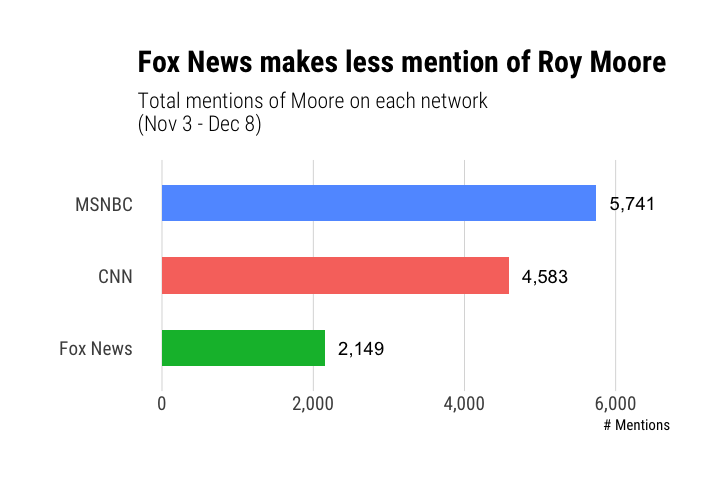

In [39]:
# bar chart of mentions of Moore since Nov 3 (small bars)

options(repr.plot.width=6, repr.plot.height=4)

ggplot(data = by_station_viz, aes(x= fct_reorder(factor(station), by_station), y=by_station, fill=factor(station))) +
  geom_bar(stat = "identity", width = 0.5) +
  geom_text(aes(label = scales::comma(by_station)), 
            position = position_identity(), hjust=-0.3) +
  scale_y_continuous(name="# Mentions", label=scales::comma, limits=c(0, 6400), expand=c(0.05,0)) +
  labs(subtitle=paste0("Total mentions of Moore on each network\n(Nov 3 - ",
                    format(lubridate::today() - 1, format="%b%e"), ")"),
      title = "Fox News makes less mention of Roy Moore") +
   scale_x_discrete(name = element_blank()) +
  theme_minimal() +
  theme_ipsum_rc(grid="XY") +
  theme(legend.position= "none", legend.title = element_blank(),
       panel.grid.major.y=element_blank()) +
  coord_flip()

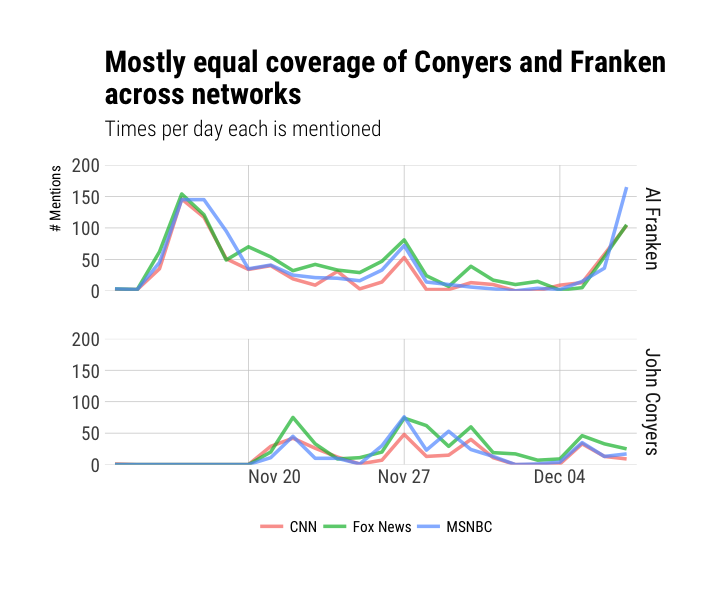

In [40]:
options(repr.plot.width=6, repr.plot.height=5)

ggplot() +
  geom_line(data = alleg_tv_date_person_station %>% 
            filter(date_start > as.Date("2017-11-13")) %>%
            filter(station %in% c("Fox News", "CNN", "MSNBC")) %>%
            filter(name %in% c("john conyers", "al franken")) %>%
            mutate(tname = title_caser(name)),
              stat="identity", aes(date_start, count_date_person_station, color=station),
           size=1, alpha=0.7)+
  facet_grid(tname ~ .) +
  scale_x_date(name=NULL, expand=c(0.02,0)) +
  scale_y_continuous(name="# Mentions", label=scales::comma, limits=c(0, 200), expand=c(0,0)) +
   ggthemes::scale_fill_tableau(name=NULL) +
  labs(title="Mostly equal coverage of Conyers and Franken \nacross networks",
      subtitle="Times per day each is mentioned") +
  theme_minimal() +
  theme_ipsum_rc(grid="XY") +
  theme(legend.position="bottom", legend.title = element_blank()) +
  theme(axis.text.x=element_text(hjust=c(0, 0.5, 0.5, 0.5, 0.5, 0.5)))

## Visualize hourly TV data

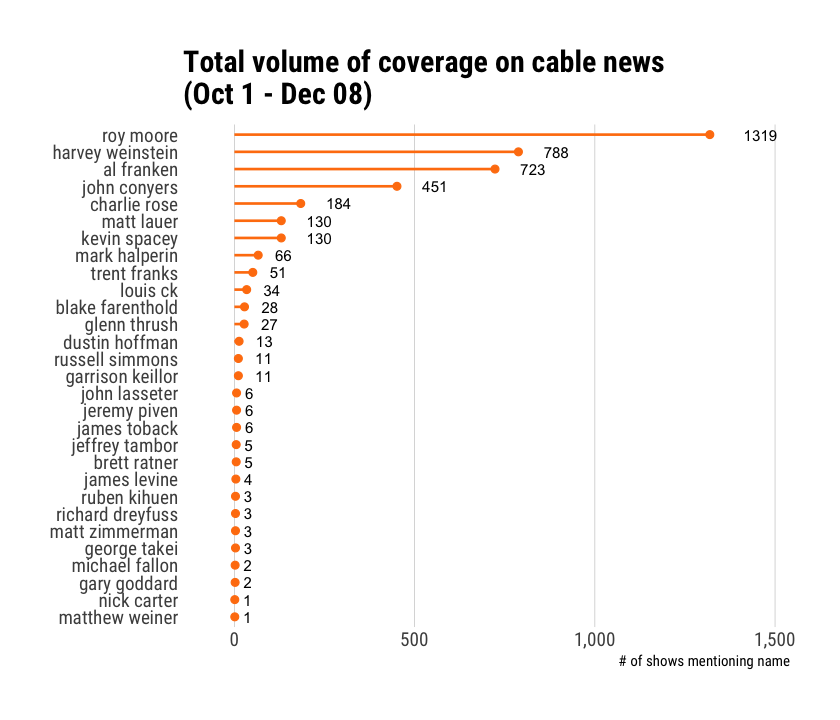

In [41]:
options(repr.plot.width=7, repr.plot.height=6) # just sets size in Jupyter nb

show_mentions_person %>%
   filter(count_show_mentions_person >0) %>%
  ggplot() +
  geom_lollipop(aes(count_show_mentions_person, reorder(name, count_show_mentions_person)), horizontal=TRUE, size=0.75,
                color=ggthemes::tableau_color_pal()(10)[2]) +
   geom_text(aes(count_show_mentions_person, reorder(name, count_show_mentions_person), label=count_show_mentions_person), hjust=-1, size = 3.2) + 
   scale_x_continuous(expand=c(0.1,2), label=scales::comma, limits=c(0,1400)) +
  labs(y=NULL, x="# of shows mentioning name",
       title=paste0("Total volume of coverage on cable news \n(Oct 1 - ", 
                    format(lubridate::today() - 1, format="%b %d"), ")")
      ) +
  theme_minimal() +
  theme_ipsum_rc(grid="X") +
  theme(panel.grid.minor.y=element_blank(),panel.grid.major.y=element_blank())

Warning message:
“Removed 311 rows containing missing values (geom_text).”

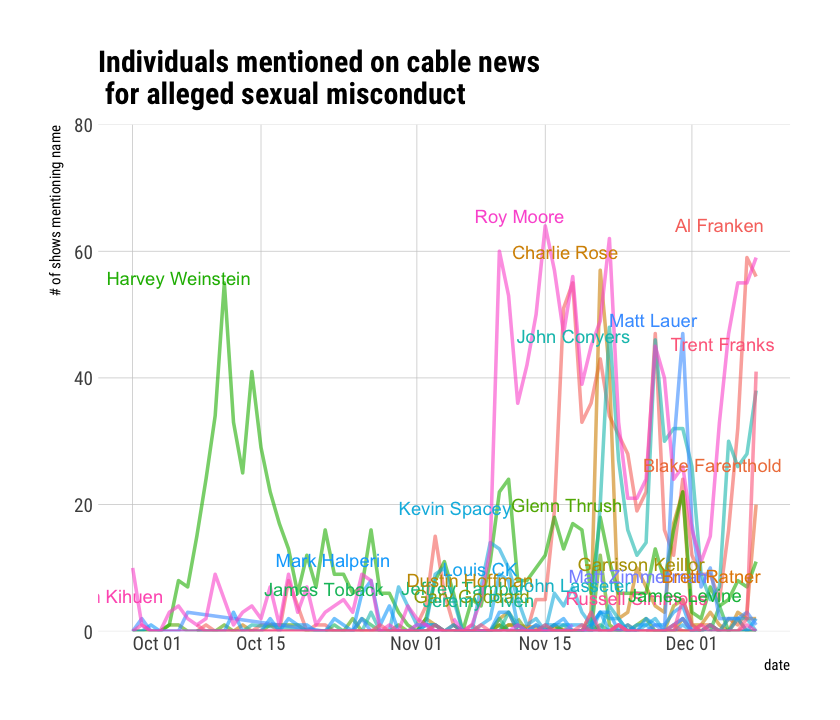

In [42]:
options(repr.plot.width=7, repr.plot.height=6)

ggplot() +
  geom_line(data = show_mentions_person_date_labeled, 
            stat="identity", 
            aes(date, count_show_mentions_person_date, color=name),
           size=1, alpha=0.6) +
  geom_text(data = show_mentions_person_date_labeled %>% 
            mutate(max = as.numeric(max)),
            aes(date, count_show_mentions_person_date, label = max_name, color = name), 
            alpha = 1, vjust = -1, hjust=0.8, position = position_jitter(height = 5)) +
  scale_y_continuous(name="# of shows mentioning name", label=scales::comma, limits=c(0, 80), expand=c(0,0)) +
  theme_minimal() +
  ggthemes::scale_fill_tableau(name=NULL) +
  labs(title="Individuals mentioned on cable news \n for alleged sexual misconduct ") +
  theme_ipsum_rc(grid="XY") +
  theme(axis.text.x=element_text(hjust=c(0, 0.5, 0.5, 0.5, 0.5, 0.5)), legend.position="none")

Warning message:
“Removed 6 rows containing missing values (geom_text).”

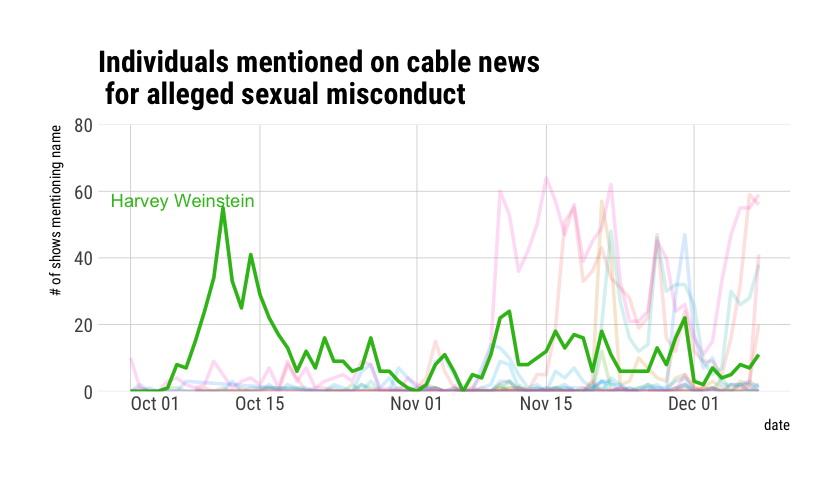

In [43]:
# Highlight Weinstein, hourly data

options(repr.plot.width=7, repr.plot.height=4)

ggplot() +
  geom_line(data = show_mentions_person_date_labeled, 
            stat="identity", 
            aes(date, count_show_mentions_person_date, color=name),
           size=1, alpha=0.2) +
  geom_line(data = show_mentions_person_date_labeled %>% # just hw
            filter(name == "harvey weinstein"), 
            stat="identity", 
            aes(date, count_show_mentions_person_date, color=name),
           size=1, alpha=0.9) +
  geom_text(data = show_mentions_person_date_labeled %>% # just hw
            mutate(max = as.numeric(max)) %>%
            filter(name == "harvey weinstein"),
              aes(date, count_show_mentions_person_date, label = max_name, color = name), 
              alpha = 0.9, vjust = -1, hjust=0.8, position = position_jitter(height = 5)) +
  scale_y_continuous(name="# of shows mentioning name", label=scales::comma, limits=c(0, 80), expand=c(0,0)) +
  theme_minimal() +
  ggthemes::scale_fill_tableau(name=NULL) +
  labs(title="Individuals mentioned on cable news \n for alleged sexual misconduct ") +
  theme_ipsum_rc(grid="XY") +
  theme(axis.text.x=element_text(hjust=c(0, 0.5, 0.5, 0.5, 0.5, 0.5)), legend.position="none")

Warning message:
“Removed 30 rows containing missing values (geom_text).”

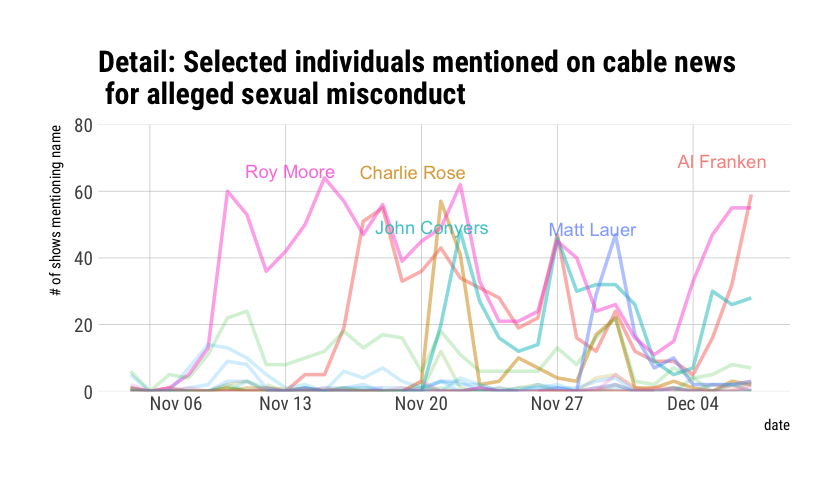

In [44]:
options(repr.plot.width=7, repr.plot.height=4)

filter_list <- c("roy moore", "al franken", "charlie rose", 
                 "matt lauer", "john conyers")

ggplot() +
  geom_line(data=show_mentions_person_date_labeled %>%
            filter(name %in% filter_list) %>%
            filter(date >= as.Date("2017-11-5") & date < lubridate::today() - 1), 
            stat="identity", 
            aes(date, count_show_mentions_person_date, color=name),
           size=1, alpha=0.5) +
  geom_line(data=show_mentions_person_date_labeled %>%
            filter(!(name %in% filter_list)) %>%
            filter(date >= as.Date("2017-11-5") & date < lubridate::today() - 1), 
            stat="identity", 
            aes(date, count_show_mentions_person_date, color=name),
           size=1, alpha=0.2) +
  geom_text(data = show_mentions_person_date_labeled %>% 
            mutate(max = as.numeric(max)) %>%
            filter(name %in% filter_list) %>%
            filter(date >= as.Date("2017-11-5") & date < lubridate::today() - 1),
            aes(date, count_show_mentions_person_date, label = max_name, color = name), 
            alpha = 0.8, vjust = -1, hjust=0.8, position = position_jitter(height = 5)) +
  scale_y_continuous(name="# of shows mentioning name", label=scales::comma, limits=c(0, 80), expand=c(0,0)) +
  theme_minimal() +
  ggthemes::scale_fill_tableau(name=NULL) +
  labs(title="Detail: Selected individuals mentioned on cable news \n for alleged sexual misconduct ") +
  theme_ipsum_rc(grid="XY") +
  theme(axis.text.x=element_text(hjust=c(0, 0.5, 0.5, 0.5, 0.5, 0.5)), legend.position="none")

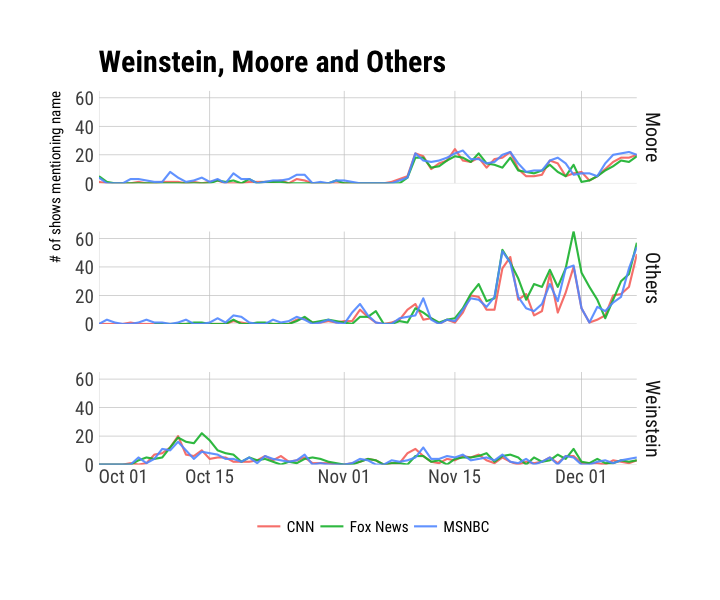

In [45]:
options(repr.plot.width=6, repr.plot.height=5)

ggplot() +
  geom_line(data = show_mentions_date_station_weinstein_moore_others %>% 
            filter(station %in% c("Fox News", "CNN", "MSNBC")),
              stat="identity", aes(as.Date(date), count_date_station_w_m_other, color=station),
           size=0.6, alpha=0.9)+
            facet_grid(w_m_other ~ .) +
    scale_x_date(name=NULL, expand=c(0,0)) +
  scale_y_continuous(name="# of shows mentioning name", label=scales::comma, limits=c(0, 65), expand=c(0,0)) +
   ggthemes::scale_fill_tableau(name=NULL) +
  labs(title="Weinstein, Moore and Others") +
  theme_minimal() +
  theme_ipsum_rc(grid="XY") +
  theme(legend.position="bottom", legend.title = element_blank()) +
  theme(axis.text.x=element_text(hjust=c(0, 0.5, 0.5, 0.5, 0.5, 0.5)))

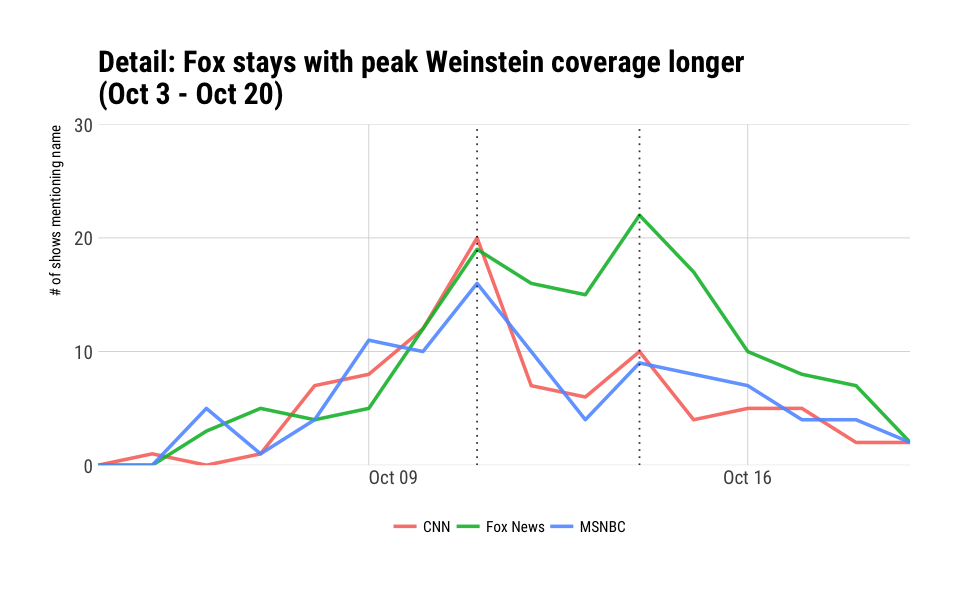

In [46]:
# Peak Weinstein

options(repr.plot.width=8, repr.plot.height=5)

ggplot() +
  geom_line(data = show_mentions_date_station_weinstein_moore_others %>% 
            filter(date > as.Date("2017-10-3") & date < as.Date("2017-10-20")) %>%
            filter(station %in% c("Fox News", "CNN", "MSNBC")) %>%
            filter(w_m_other == "Weinstein"),
              stat="identity", aes(as.Date(date), count_date_station_w_m_other, color=station),
           size=1, alpha=0.9)+
    geom_vline(xintercept=c(as.Date("2017-10-11"), as.Date("2017-10-14")), linetype=3, alpha=0.8) +
    scale_x_date(name=NULL, expand=c(0,0)) +
  scale_y_continuous(name="# of shows mentioning name", label=scales::comma, limits=c(0, 30), expand=c(0,0)) +
   ggthemes::scale_fill_tableau(name=NULL) +
  labs(title="Detail: Fox stays with peak Weinstein coverage longer \n(Oct 3 - Oct 20)") +
  theme_minimal() +
  theme_ipsum_rc(grid="XY") +
  theme(legend.position="bottom", legend.title = element_blank()) +
  theme(axis.text.x=element_text(hjust=c(0, 0.5, 0.5, 0.5, 0.5, 0.5)))

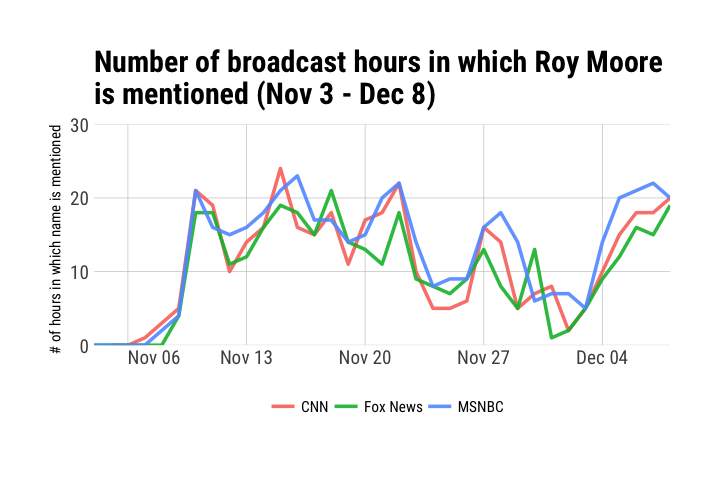

In [47]:
# Peak Weinstein

options(repr.plot.width=6, repr.plot.height=4)

ggplot() +
  geom_line(data = show_mentions_date_station_weinstein_moore_others %>% 
            filter(date > as.Date("2017-11-3")) %>%
            filter(station %in% c("Fox News", "CNN", "MSNBC")) %>%
            filter(w_m_other == "Moore"),
              stat="identity", aes(as.Date(date), count_date_station_w_m_other, color=station),
           size=1, alpha=0.9)+
    scale_x_date(name=NULL, expand=c(0,0)) +
  scale_y_continuous(name="# of hours in which name is mentioned", label=scales::comma, limits=c(0, 30), expand=c(0,0)) +
   ggthemes::scale_fill_tableau(name=NULL) +
  labs(title=paste0("Number of broadcast hours in which Roy Moore \nis mentioned (Nov 3 - ",
                    format(lubridate::today() - 1, format="%b%e"), ")")) +
  theme_minimal() +
  theme_ipsum_rc(grid="XY") +
  theme(legend.position="bottom", legend.title = element_blank()) +
  theme(axis.text.x=element_text(hjust=c(0, 0.5, 0.5, 0.5, 0.5, 0.5)))


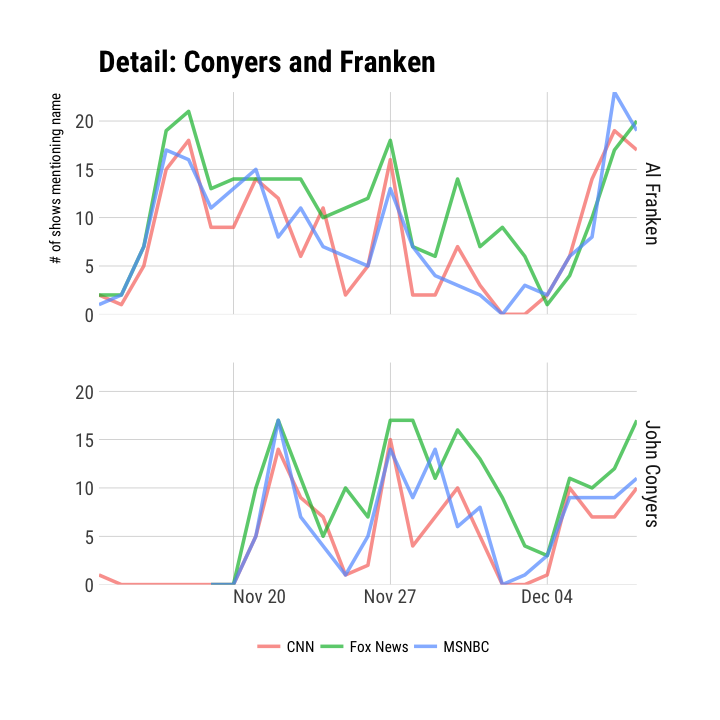

In [48]:
options(repr.plot.width=6, repr.plot.height=6)

ggplot() +
  geom_line(data = show_mentions_person_station_date %>% 
            filter(date > as.Date("2017-11-13")) %>%
            filter(station %in% c("Fox News", "CNN", "MSNBC")) %>%
            filter(name %in% c("john conyers", "al franken")) %>%
            mutate(tname = title_caser(name)),
              stat="identity", aes(as.Date(date), count_show_mentions_person_station_date, color=station),
           size=1, alpha=0.7)+
  facet_grid(tname ~ .) +
  scale_x_date(name=NULL, expand=c(0,0)) +
  scale_y_continuous(name="# of shows mentioning name", label=scales::comma, limits=c(0, 23), expand=c(0,0)) +
   ggthemes::scale_fill_tableau(name=NULL) +
  labs(title="Detail: Conyers and Franken") +
  theme_minimal() +
  theme_ipsum_rc(grid="XY") +
  theme(legend.position="bottom", legend.title = element_blank()) +
  theme(axis.text.x=element_text(hjust=c(0, 0.5, 0.5, 0.5, 0.5, 0.5)))

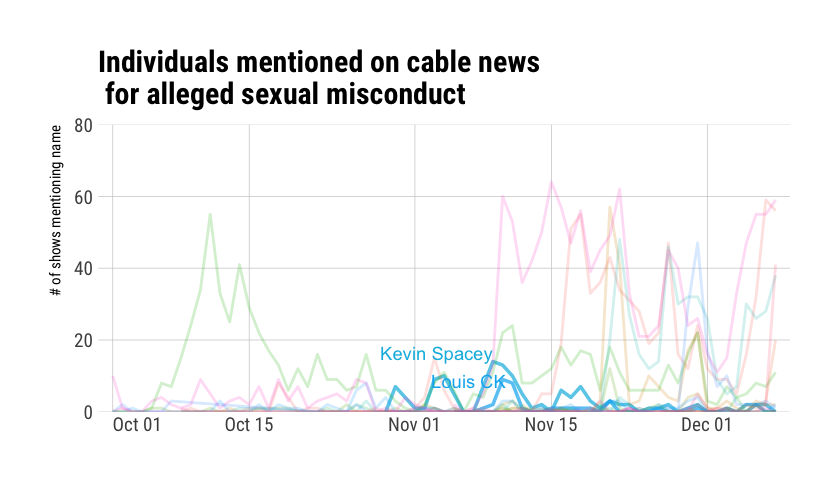

In [49]:
# Highlighting CK and Spacey
options(repr.plot.width=7, repr.plot.height=4)

filter_list <- c("louis ck", "kevin spacey")

ggplot() +
  geom_line(data = show_mentions_person_date %>%
            filter(name %in% filter_list), # highlighting
            stat="identity", 
            aes(as.Date(date), count_show_mentions_person_date, color=name),
           size=1, alpha=0.7) +
  geom_line(data = show_mentions_person_date_labeled %>%
            filter(!(name %in% filter_list)), # highlighting
            stat="identity", 
            aes(as.Date(date), count_show_mentions_person_date, color=name),
           size=0.8, alpha=0.2) +
  geom_text(data = show_mentions_person_date_labeled %>%
            mutate(max = as.numeric(max)) %>%
            filter(!is.na(max)) %>%
            filter(max > 2) %>%
            filter(name %in% filter_list), # highlighting
            aes(as.Date(date), count_show_mentions_person_date, label = max_name, color = name), 
            alpha = 1, vjust = -0.2, hjust=1, position = position_jitter(height = 4)) +
  scale_x_date(name=NULL, expand=c(0,1.5)) +
  scale_y_continuous(name="# of shows mentioning name", label=scales::comma, limits=c(0, 80), expand=c(0,0)) +
  theme_minimal() +
  ggthemes::scale_fill_tableau(name=NULL) +
  labs(title="Individuals mentioned on cable news \n for alleged sexual misconduct ") +
  theme_ipsum_rc(grid="XY") +
  theme(axis.text.x=element_text(hjust=c(0, 0.5, 0.5, 0.5, 0.5, 0.5)), legend.position="none")

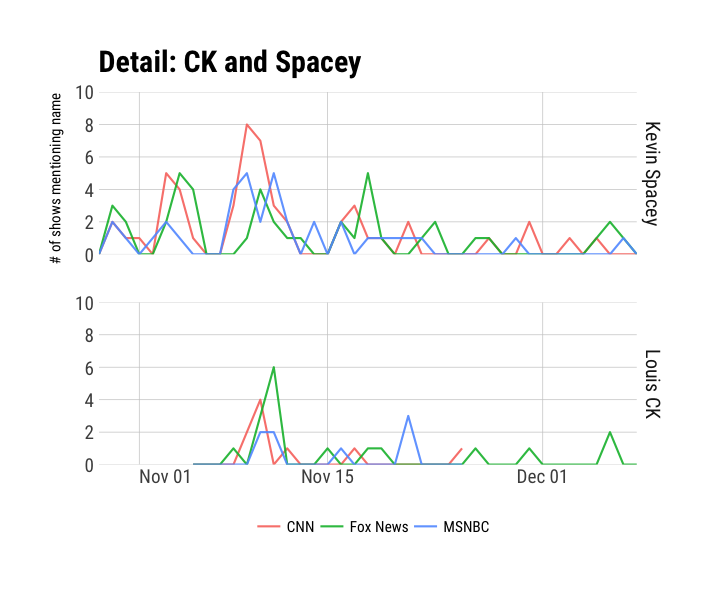

In [50]:
options(repr.plot.width=6, repr.plot.height=5)

ggplot() +
  geom_line(data = show_mentions_person_station_date %>% 
            filter(station %in% c("Fox News", "CNN", "MSNBC")) %>%
            filter(name %in% c("kevin spacey", "louis ck")) %>%
            mutate(tname = title_caser(name)),
              stat="identity", aes(as.Date(date), count_show_mentions_person_station_date, color=station),
           size=0.6, alpha=0.9) +
  facet_grid(tname ~ .) +
  scale_x_date(name=NULL, expand=c(0,0)) +
  scale_y_continuous(name="# of shows mentioning name", label=scales::comma, limits=c(0, 10), expand=c(0,0),
                    breaks= scales::pretty_breaks()) +
   ggthemes::scale_fill_tableau(name=NULL) +
  labs(title="Detail: CK and Spacey") +
  theme_minimal() +
  theme_ipsum_rc(grid="XY") +
  theme(legend.position="bottom", legend.title = element_blank()) +
  theme(axis.text.x=element_text(hjust=c(0, 0.5, 0.5, 0.5, 0.5, 0.5)))

## Visualize Google Trends data

Warning message:
“Removed 963 rows containing missing values (geom_text).”

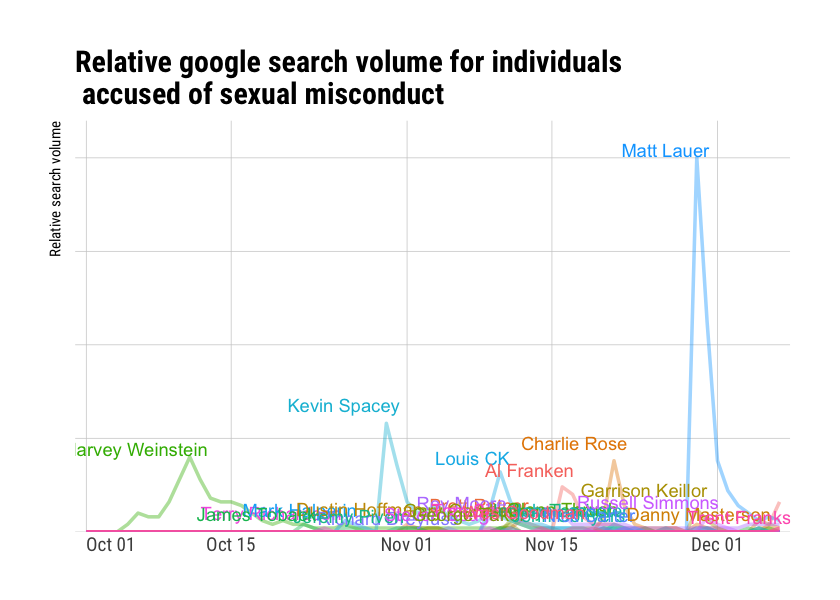

In [51]:
options(repr.plot.width=7, repr.plot.height=5)

ggplot(data = alleg_search_long_labeled, aes(x=lubridate::date(date), y=value, color=name)) +
  geom_line(size=1, alpha=0.4) +
  geom_text(aes(label=max_name), alpha=1, hjust=0.9, vjust=-0.5, position = position_jitter(height = 2)) +
  theme_minimal() +
  theme(axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
       legend.position="none") +
   scale_x_date(name=NULL, expand=c(0,0.7)) +
  scale_y_continuous(name="Relative search volume", label=scales::comma, limits=c(0, 110), expand=c(0,0)) +
  theme_minimal() +
  ggthemes::scale_fill_tableau(name=NULL) +
  labs(title="Relative google search volume for individuals \n accused of sexual misconduct ") +
  theme_ipsum_rc(grid="XY") +
  theme(axis.text.x=element_text(hjust=c(0, 0.5, 0.5, 0.5, 0.5, 0.5)), 
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
        legend.position="none")

Warning message:
“Removed 194 rows containing missing values (geom_text).”

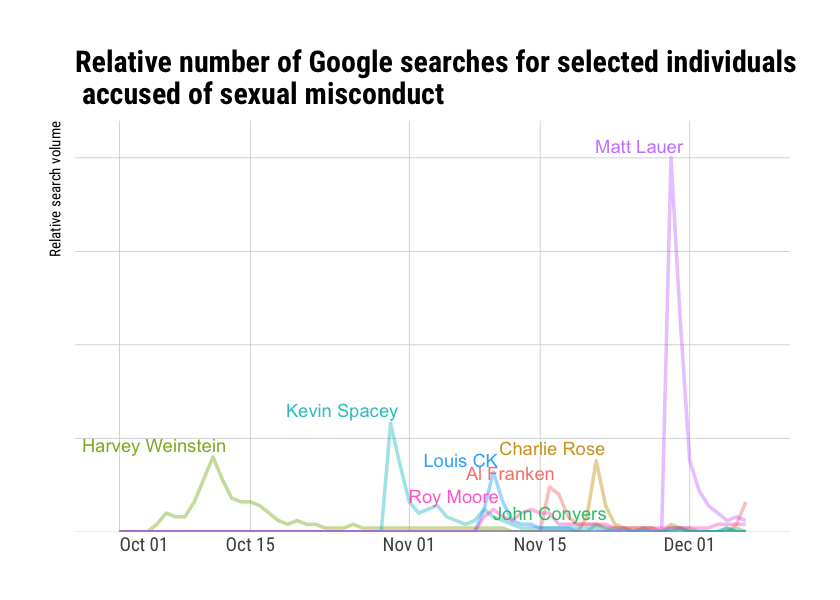

In [52]:
options(repr.plot.width=7, repr.plot.height=5)

gtrends_viz <-
  alleg_search_long_labeled %>%
  filter(name %in% text_placement_list) %>%
  filter(name %in%
       (gtrends_max_values %>% filter(max_value_by_name > 5 | name == "john conyers") %>% .$name)
                  ) %>%
  arrange(name) %>%
  mutate(max_name_last = str_extract(max_name, "\\b\\w+$"))

ggplot() +
  geom_line(data = gtrends_viz,
        aes(x=lubridate::date(date), y=value, color=name), size=1, alpha=0.4) +
  geom_text(data = gtrends_viz,
      aes(x=lubridate::date(date), y=value, color=name, label=max_name), 
            alpha=0.9, hjust=0.9, vjust=-0.5, position = position_jitter(height = 0.5)) +
  theme_minimal() +
  theme(axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
       legend.position="none") +
    scale_x_date(name=NULL, expand=c(0.05,1)) +
  scale_y_continuous(name="Relative search volume", label=scales::comma, limits=c(0, 110), expand=c(0,0)) +
  theme_minimal() +
  ggthemes::scale_fill_tableau(name=NULL) +
  labs(title="Relative number of Google searches for selected individuals \n accused of sexual misconduct ") +
  theme_ipsum_rc(grid="XY") +
  theme(axis.text.x=element_text(hjust=c(0, 0.5, 0.5, 0.5, 0.5, 0.5)), 
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
        legend.position="none")

---

---

---